In [11]:
#@title File Locations
state_param_file = "../data/us-wa/wa_state_parameters_transpose.csv" #@param {type:"string"}
county_households_file = "../data/us-wa/wa_county_household_demographics.csv" #@param {type:"string"}
county_params_file = "../data/us-wa/wa_county_parameters.csv" #@param {type:"string"}
county_occupation_file = "../data/us-wa/wa_county_occupation_networks.csv"  #@param {type:"string"}

In [12]:
%load_ext autoreload
%autoreload 1
%aimport county_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import county_utils as utils
from county_utils import AggregateModel
import numpy as np
import pandas as pd

In [14]:
local_params = {
    "lockdown_days": 35,
    "app_turned_on": 1,
    "custom_occupation_network": 1,
}

In [19]:
model = AggregateModel([state_param_file], county_households_file, county_occupation_file, county_params_file, local_params)

In [54]:
results = model.run_counties([53039,53031,53017,53047])

Batch progress: 100%|██████████| 4/4 [00:42<00:00, 10.54s/it]


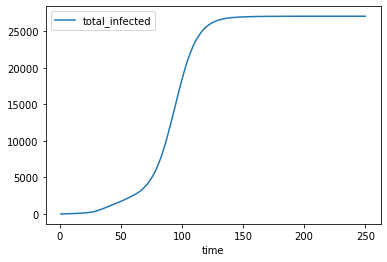

In [43]:
list(results.values())[0][1].plot(x='time', y='total_infected')

In [69]:
model.write_results("results/small_counties")

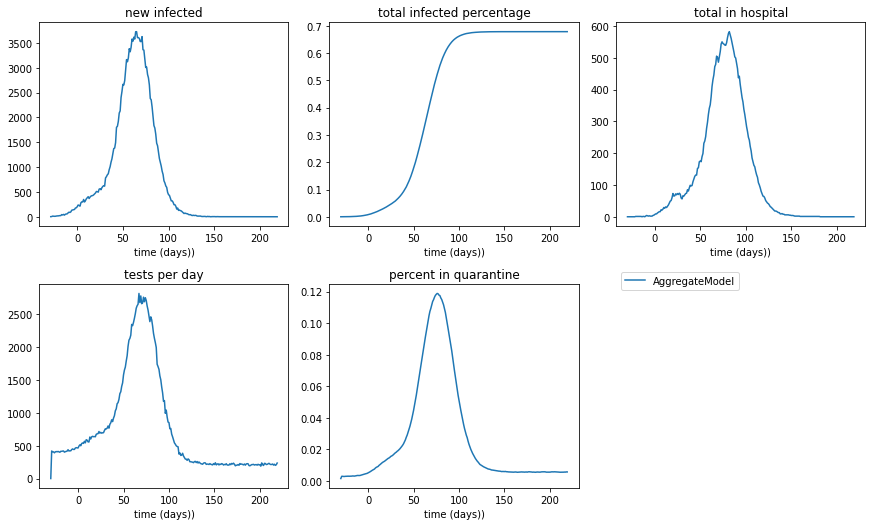

In [74]:
model.plot_results()

In [95]:
merged_params = pd.read_csv("results/small_counties/merged_params.csv").loc[0].to_dict()
merged_results = pd.read_csv("results/small_counties/merged_results.csv")

In [96]:
merged_results

,time,lockdown,test_on_symptoms,app_turned_on,total_infected,total_infected_0_9,total_infected_10_19,total_infected_20_29,total_infected_30_39,total_infected_40_49,...,n_recovered,hospital_admissions,hospital_admissions_total,hospital_to_critical_daily,hospital_to_critical_total,new_infected,new_death,total_infected_rate,quarantine_rate,time (days))
0,1,0,4,0,20,3,2,5,0,2,...,0,0,0,0,0,NaN,NaN,0.000079,0.001592,-30.0
1,2,0,4,0,22,3,2,5,1,2,...,0,0,0,0,0,2.0,0.0,0.000087,0.003010,-29.0
2,3,0,4,0,26,3,2,7,2,2,...,0,0,0,0,0,4.0,0.0,0.000103,0.003010,-28.0
3,4,0,4,0,39,3,3,11,2,2,...,0,0,0,0,0,13.0,0.0,0.000154,0.002911,-27.0
4,5,0,4,0,50,4,4,11,5,2,...,0,0,0,0,0,11.0,0.0,0.000197,0.002915,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0,4,0,171838,9901,18880,21404,19801,24448,...,170457,0,0,0,445,0.0,0.0,0.678737,0.005636,215.0
246,247,0,4,0,171838,9901,18880,21404,19801,24448,...,170457,0,0,0,445,0.0,0.0,0.678737,0.005696,216.0
247,248,0,4,0,171838,9901,18880,21404,19801,24448,...,170457,0,0,0,445,0.0,0.0,0.678737,0.005668,217.0
248,249,0,4,0,171838,9901,18880,21404,19801,24448,...,170457,0,0,0,445,0.0,0.0,0.678737,0.005791,218.0


In [86]:
merged_params.time_offset = 0

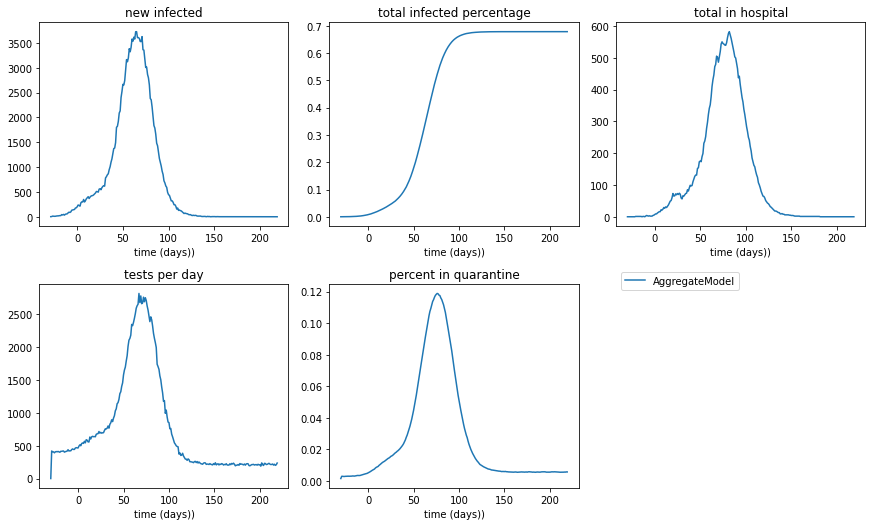

In [97]:
utils.sim_display([[merged_params, merged_results]],["AggregateModel"])

In [25]:
sim_results = utils.read_results("results/us-wa")

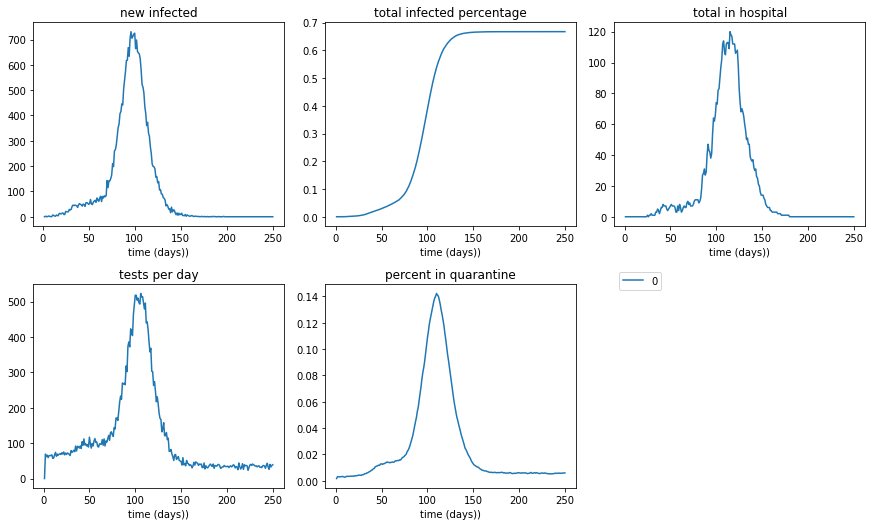

In [26]:
utils.sim_display(sim_results[0], sim_results[1])

In [44]:
results_no_custom_occu = model.run_county(model.counties[0], {"custom_occupation_network": 0})

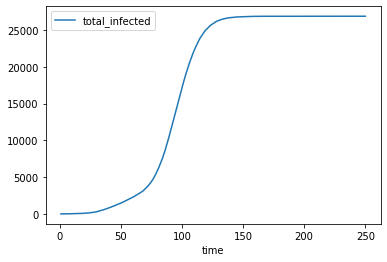

In [45]:
results_no_custom_occu[1].plot(x='time', y='total_infected')

In [49]:
np.where(list(results.values())[0][1].lockdown == 1), np.where(results_no_custom_occu[1].lockdown == 1)

((array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
         65]),),
 (array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
         50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
         67]),))